*Note*:The process of *connecting adjacent pixels* is already handled in
/shared/data/climateplus2025/Postprocessing_for_poster_3_images_Sep16/post_processing_stage_1_0916.py.

Input
- Original TIF images
- Ground Truth;Orignal Annotation in GPKG format
- Prediction;Geom level Prediction in GPKG format(from post-processing stage3)

(Oct10) Group_neighboring_polygons rule summary <br>
- The purpose of grouping neighboring polygons is to connect predictions near object boundaries that are within 2 pixels (distance less than 16 cm). *!Adjacent polygons seperated near boarder are typically only two polygons away!*
When adjacent polygons belong to different classes, we do not merge them.
- This is because we are evaluating how post-processing affects Precision and Recall, not reinterpreting class semantics.
- Therefore, merging across classes could artificially impact class-level TP/FP/FN counts, making the evaluation unreliable.
Adjacent but different-class polygons should remain separate.

(Oct10) Drop_small_objects <br>
- Based on the GT data from the three images, we computed the area distribution (in m²) of annotated objects for the three target classes.
- Compared these distributions to the actual physical size of a single PV panel (approximately 1.7 m²) to guide threshold selection.

**Load data and align CRS**

In [ ]:
import geopandas as gpd
import pandas as pd
import glob
import os
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon
import numpy as np
import matplotlib.pyplot as plt

# Load GT
gt = gpd.read_file(
    "/shared/data/climateplus2025/Prediction_for_poster_3_images_July21/0.Image_files_selection/final_annotations_PV_all_types_balanced_3_cleaned.gpkg"
)

# Load all prediction(after post_processing stage3) output from our model
pred_dir = "/shared/data/climateplus2025/Postprocessing_for_poster_3_images_1024_Nov20/output_stage_3"
gpkg_files = glob.glob(os.path.join(pred_dir, "*.gpkg"))
print(f"Found {len(gpkg_files)} prediction GPKG files")

prd_list = [gpd.read_file(f) for f in gpkg_files]

prd = gpd.GeoDataFrame(
    pd.concat(prd_list, ignore_index=True),
    geometry="geometry",
    crs=prd_list[0].crs  # keep CRS from first file
)

display(gt.head(3))
display(prd.sample(3))

# Aligning CRS ESRI:102562 (GT gpkg) 
print("=== CRS diagnostics ===")
print(f"GT CRS   : {gt.crs}")
print(f"Pred CRS : {prd.crs}")

if (gt.crs is None) or (prd.crs is None):
    print("WARNING: One or both GeoDataFrames have no CRS. "
          "Set CRS appropriately before area/IoU computations.")
else:
    if gt.crs == prd.crs:
        print("CRS match (no reprojection needed)")
    else:
        print("CRS mismatch → reprojecting predictions to GT CRS ...")
        prd = prd.to_crs(gt.crs)
        print(f"Done. Pred CRS (new): {prd.crs}")
        print("CRS now aligned")

    try:
        if gt.crs.is_geographic:
            print("NOTE: GT CRS is geographic (degrees). "
                  "Areas/IoU in degrees are not meaningful. "
                  "Consider projecting to a metric CRS (e.g., UTM) before evaluation.")
    except Exception:
        pass


Found 3 prediction GPKG files


,id,PV_normal,PV_heater,PV_pool,uncertflag,area,annotator,centroid_latitude,centroid_longitude,image_name,...,se_corner_of_image_longitude,PV_normal_qc,PV_heater_qc,PV_pool_qc,PV_heater_mat_qc,uncertflag_qc,delete_qc,resizing_qc,PV_heater_mat_combined,geometry
0,4208,0,0,1,0,11.698338,fiona,-3.771013e+06,-52879.308635,2023_RGB_8cm_W57B_8,...,-52000.0,0,0,1,0,0,0,0,0,"POLYGON ((-52883.171 -3771011.424, -52882.308 ..."
1,4209,0,0,1,0,7.228464,fiona,-3.771003e+06,-52888.007219,2023_RGB_8cm_W57B_8,...,-52000.0,0,0,1,0,0,0,0,0,"POLYGON ((-52887.001 -3771000.514, -52885.919 ..."
2,4210,0,0,1,0,7.469909,fiona,-3.771094e+06,-52865.447428,2023_RGB_8cm_W57B_8,...,-52000.0,0,0,1,0,0,0,0,0,"POLYGON ((-52866.993 -3771092.457, -52863.88 -..."


,prediction_id,image_id,label,area_m2,polygon_centroid_pixel_y_x_,polygon_centroid_CRS_X_Y_,polygon_centroid_GPS_lat_lon_,vertex_count,geometry
264,i_2023_RGB_8cm_W57B_8_pred_e9f2a6aa,i_2023_RGB_8cm_W57B_8,PV_normal,9.2704,"[10178,4116]","[-52670.68,-3771814.28]","[-34.07217528,18.42939762]",167,"MULTIPOLYGON (((-52672.28 -3771811.32, -52672...."
569,i_2023_RGB_8cm_W24A_17_pred_a113e9cc,i_2023_RGB_8cm_W24A_17,PV_normal,0.0384,"[6719,10898]","[-28128.12,-3743537.56]","[-33.81820002,18.69617925]",14,"MULTIPOLYGON (((-28128.28 -3743537.48, -28128...."
30,i_2023_RGB_8cm_W25C_16_pred_8974dbda,i_2023_RGB_8cm_W25C_16,PV_normal,10.4928,"[11388,6588]","[-29472.92,-3758911.08]","[-33.95676086,18.68113857]",189,"MULTIPOLYGON (((-29475.64 -3758909.88, -29475...."


=== CRS diagnostics ===
GT CRS   : PROJCS["GCS_WGS_1984",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722356049,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",19],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Pred CRS : PROJCS["Hartebeesthoek94_Lo19_(E-N)",GEOGCS["Hartebeesthoek94",DATUM["Hartebeesthoek94",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6148"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4148"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",19],PARAMETER["

**Setup configuration**

- IOU_THRESHOLD = 0.50 → Minimum IoU required to count a prediction as a true match. (0.5 is good practice)
- EPS_FACTOR = 1e-6 → Ignores extremely tiny overlaps caused by numerical noise.
- CLASS_FLAGS = [...] → List of GT class indicator columns used in evaluation.

In [7]:
IOU_THRESHOLD = 0.50 # IoU threshold to mark a GT as "covered"
EPS_FACTOR = 1e-6 # ignore tiny overlaps: area(pred ∩ GT) > EPS_FACTOR * area(GT)
CLASS_FLAGS = ["PV_normal", "PV_heater", "PV_pool"] # GT OHE columns

**Data Preparation;OHE**
- Converting the GT dataset from one-hot encoded (OHE) classes into a long format with a single categorical column(label)

In [8]:
single = gt.loc[gt[CLASS_FLAGS].sum(axis=1) == 1].copy()
single["label"] = single[CLASS_FLAGS].idxmax(axis=1)

weird = gt.loc[gt[CLASS_FLAGS].sum(axis=1) != 1].copy()
if not weird.empty:
    parts = []
    for c in CLASS_FLAGS:
        part = weird.loc[weird[c] == 1, gt.columns].copy()
        if not part.empty:
            part["label"] = c
            parts.append(part)
    weird_long = pd.concat(parts, ignore_index=True) if parts else weird.assign(label=np.nan)
else:
    weird_long = weird.assign(label=np.nan)

gt_long = pd.concat([single, weird_long], ignore_index=True).dropna(subset=["label"])
gt_long = gpd.GeoDataFrame(gt_long, geometry="geometry", crs=gt.crs)

gt_long = gt_long.explode(index_parts=False, ignore_index=True)
display(gt_long.sample())
display(gt_long["label"].value_counts())

,id,PV_normal,PV_heater,PV_pool,uncertflag,area,annotator,centroid_latitude,centroid_longitude,image_name,...,PV_normal_qc,PV_heater_qc,PV_pool_qc,PV_heater_mat_qc,uncertflag_qc,delete_qc,resizing_qc,PV_heater_mat_combined,label,geometry
249,4459,1,0,0,0,25.303074,fiona,-3.771959e+06,-52473.136746,2023_RGB_8cm_W57B_8,...,1,0,0,0,0,0,0,0,PV_normal,"POLYGON ((-52473.337 -3771955.044, -52469.549 ..."


label
PV_normal    337
PV_heater    316
PV_pool      236
Name: count, dtype: int64

**Data Preparation;Overlap**

- Clipping predictions to GT polygons and removing tiny overlaps (<0.001m^2)
- Checking if multiple predictions overlap within the same ground truth
- Recording intersections among predictions to check

In [9]:
from itertools import combinations

def check_pairwise_pred_overlap_within_gt(
    gt_gdf: gpd.GeoDataFrame,
    pred_gdf: gpd.GeoDataFrame,
    label_col: str = "label",
    image_col: str = "image_name",
    pred_id_col: str = "prediction_id",
    pred_label_col: str = "label",
    eps_factor: float = EPS_FACTOR,
):
    """
    Returns:
      per_gt_overlap_flag: [gt_idx, has_pred_pair_overlap, image_name]
      pred_pair_overlaps : [gt_idx, image_name, gt_label,
                            pred1_id, pred1_label, pred2_id, pred2_label,
                            overlap_area_within_gt]
    """
    gt_gdf  = gpd.GeoDataFrame(gt_gdf, geometry="geometry", crs=gt_gdf.crs)
    pred_gdf = gpd.GeoDataFrame(pred_gdf, geometry="geometry", crs=pred_gdf.crs)

    gt_exp = gt_gdf.explode(index_parts=False, ignore_index=True)

    flags, rows = [], []

    for gi, grow in gt_exp.reset_index(drop=True).iterrows():
        g = grow.geometry
        gt_label = grow[label_col] if label_col in grow else None
        gt_image = grow[image_col] if image_col in grow else None

        if g is None or g.is_empty:
            flags.append((gi, False, gt_image))
            continue

        # candidate predictions
        if getattr(pred_gdf, "sindex", None) is not None:
            cand_idx = list(pred_gdf.sindex.query(g, predicate="intersects"))
            candidates = pred_gdf.iloc[cand_idx].reset_index(drop=True)
        else:
            candidates = pred_gdf[pred_gdf.intersects(g)].reset_index(drop=True)

        # clip to GT & filter tiny pieces
        parts = []
        min_area = eps_factor * g.area
        for _, prow in candidates.iterrows():
            inter = prow.geometry.intersection(g)
            if not inter.is_empty and inter.area > min_area:
                pred_id = prow[pred_id_col] if pred_id_col in prow else _
                pred_label = prow[pred_label_col] if pred_label_col in prow else None
                parts.append((pred_id, pred_label, inter))

        # pairwise overlaps
        any_overlap = False
        for (id1, label1, geom1), (id2, label2, geom2) in combinations(parts, 2):
            ov = geom1.intersection(geom2)
            if not ov.is_empty and ov.area > 0.0:
                any_overlap = True
                rows.append((gi, gt_image, gt_label,
                             id1, label1, id2, label2,
                             ov.area))

        flags.append((gi, any_overlap, gt_image))

    per_gt_overlap_flag = pd.DataFrame(
        flags, columns=["gt_idx", "has_pred_pair_overlap", "image_name"]
    )
    pred_pair_overlaps = pd.DataFrame(
        rows,
        columns=["gt_idx", "image_name", "gt_label",
                 "pred1", "pred1_label", "pred2", "pred2_label",
                 "overlap_area_within_gt"]
    )
    return per_gt_overlap_flag, pred_pair_overlaps

per_gt_pair_flag, pred_pair_overlaps = check_pairwise_pred_overlap_within_gt(
    gt_gdf=gt_long,
    pred_gdf=prd,
    label_col="label",
    image_col="image_name",
    pred_id_col="prediction_id",
    pred_label_col="label",
    eps_factor=EPS_FACTOR
)

print(f"GTs with overlapping prediction pairs (within GT): "
      f"{per_gt_pair_flag['has_pred_pair_overlap'].sum()} / {len(per_gt_pair_flag)}")
display(pred_pair_overlaps.head(20))


GTs with overlapping prediction pairs (within GT): 0 / 889


,gt_idx,image_name,gt_label,pred1,pred1_label,pred2,pred2_label,overlap_area_within_gt


**Data Preparation:Table combination and Overlap**

This function performs GT–Prediction association for instance-level evaluation.

1. GT polygons are exploded (one row per polygon).  
   For each GT polygon:
   - Find all predicted polygons that spatially intersect the GT.
   - Split them into: same-class predictions & different-class predictions

2. Same-class predictions inside a GT:
   - All predictions of the same class intersecting the GT are merged into a
     single union polygon using unary_union, even if they are spatially
     disconnected.
   - Their prediction IDs and metadata (area, centroids, image name) are
     aggregated and stored.
   - This merged geometry represents the model’s “combined prediction”
     for that GT object.

3. Different-class predictions intersecting the GT:
   - Each one is treated independently as a class-mismatch false positive.
   - They are added as separate rows with match_type = "diff_class".

4. Predictions that do not intersect any GT polygon:
   - These are recorded as pure false positives with match_type = "outside".

5. The function returns a DataFrame summarizing:
   - which GT polygon (gt_idx) each prediction relates to
   - the list of prediction IDs associated with that GT
   - the merged predicted geometry (union_pred_geom)
   - majority or assigned prediction label
   - metadata (areas, pixel/CRS/GPS centroids)
   - match category: "same_class", "diff_class", or "outside"

This table is the foundation for later IoU computation, TP/FP classification,
and final instance-level evaluation metrics.


In [10]:
from shapely.ops import unary_union
import pandas as pd
import geopandas as gpd

def build_gt_pred_union_table_with_outside(
    gt_gdf: gpd.GeoDataFrame,
    pred_gdf: gpd.GeoDataFrame,
    gt_label_col: str = "label",
    pred_label_col: str = "label",
    pred_id_col: str = "prediction_id",
    eps_factor: float = 1e-6,
    iou_thr: float = 0.5,
):
    """
    Extended version: includes original prediction metadata (area, centroid, etc.) and fixes column mismatch error.
    """
    results = []
    used_pred_ids = set()

    gt_exp = gt_gdf.explode(index_parts=False, ignore_index=True)

    for gi, grow in gt_exp.iterrows():
        g = grow.geometry
        gt_label = grow[gt_label_col]

        if g is None or g.is_empty:
            results.append((gi, gt_label, [], None, None, None, None))
            continue

        # find intersecting predictions
        cand_idx = list(pred_gdf.sindex.query(g, predicate="intersects")) \
            if getattr(pred_gdf, "sindex", None) is not None else []
        candidates = pred_gdf.iloc[cand_idx].reset_index(drop=True) if cand_idx else pred_gdf[pred_gdf.intersects(g)]

        if candidates.empty:
            results.append((gi, gt_label, [], None, None, None, None))
            continue

        same_class = candidates[candidates[pred_label_col] == gt_label]
        diff_class = candidates[candidates[pred_label_col] != gt_label]

        # --- same-class union ---
        if not same_class.empty:
            valid_geoms = [r.geometry for _, r in same_class.iterrows() if r.geometry.is_valid]
            merged_geom = unary_union(valid_geoms) if valid_geoms else None
            pred_ids = list(same_class[pred_id_col])
            used_pred_ids.update(pred_ids)

            def join_col(col):
                if col in same_class.columns:
                    return ";".join(map(str, same_class[col].tolist()))
                return None

            meta = {
                "image_name": join_col("image_name"),
                "area_m2_list": join_col("area_m2"),
                "centroid_pixel": join_col("polygon_centroid_pixel[y,x]"),
                "centroid_gps": join_col("polygon_centroid_GPS[lat,lon]"),
            }

            results.append((gi, gt_label, pred_ids, gt_label, merged_geom, "same_class", meta))

        # --- different-class predictions (FP_mismatch) ---
        for _, prow in diff_class.iterrows():
            meta = {
                "image_name": prow.get("image_name"),
                "area_m2_list": prow.get("area_m2"),
                "centroid_pixel": prow.get("polygon_centroid_pixel[y,x]"),
                "centroid_gps": prow.get("polygon_centroid_GPS[lat,lon]"),
            }
            results.append((gi, gt_label, [prow[pred_id_col]], prow[pred_label_col], prow.geometry, "diff_class", meta))
            used_pred_ids.add(prow[pred_id_col])

    # --- predictions outside GT (FP_pure) ---
    outside_preds = pred_gdf.loc[~pred_gdf[pred_id_col].isin(used_pred_ids)]
    for _, prow in outside_preds.iterrows():
        meta = {
            "image_name": prow.get("image_name"),
            "area_m2_list": prow.get("area_m2"),
            "centroid_pixel": prow.get("polygon_centroid_pixel[y,x]"),
            "centroid_gps": prow.get("polygon_centroid_GPS[lat,lon]"),
        }
        results.append((None, None, [prow[pred_id_col]], prow[pred_label_col], prow.geometry, "outside", meta))
    union_df = pd.DataFrame(
        results,
        columns=[
            "gt_idx",
            "gt_label",
            "pred_ids",
            "majority_pred_label",
            "union_pred_geom",
            "match_type",
            "metadata"
        ]
    )

    return union_df

**Data Preparating;Cleaning noise**

Prepares and cleans matched GT–prediction geometries by removing noise, fixing geometry types, and ensuring only valid polygons remain for evaluation.

* Builds a GT–prediction matching table and cleans geometries.
* Merges all same-class predictions that intersect a GT polygon into one union polygon.
* Keeps different-class predictions as separate false positives.
* Keeps predictions outside any GT as false positives.
* Removes non-polygon geometries (points, lines, noisy collections) and retains only valid polygons for evaluation.

In [11]:
# -------------------------------------------------------------------
# 1. Build GT–Prediction Union Table (includes metadata)
# -------------------------------------------------------------------
union_df = build_gt_pred_union_table_with_outside(
    gt_gdf=gt_long,
    pred_gdf=prd,
    gt_label_col="label",
    pred_label_col="label",
    pred_id_col="prediction_id",
    eps_factor=EPS_FACTOR,
    iou_thr=IOU_THRESHOLD
)

print("Union_df successfully created with shape:", union_df.shape)
display(union_df.head(5))

union_df = union_df.rename(columns={"majority_pred_label": "pred_label"})
print("Renamed 'majority_pred_label' → 'pred_label' for clarity.")

# -------------------------------------------------------------------
# 2. Clean union_df
# -------------------------------------------------------------------
def clean_union_df(union_df):
    """
    Clean mixed-class and overlapping predictions.
      - Keep pred_ids and metadata for later traceability.
      - Only clean geometries.
    """
    from shapely.geometry import Polygon, MultiPolygon
    from shapely.ops import unary_union

    cleaned_rows = []

    for _, row in union_df.iterrows():
        gt_idx = row["gt_idx"]
        gt_label = row["gt_label"]
        pred_label = row["pred_label"]
        pred_ids = row.get("pred_ids", None)
        match_type = row.get("match_type", None)
        # metadata = row.get("metadata", None)
        union_geom = row["union_pred_geom"]

        if union_geom is None or union_geom.is_empty:
            clean_geom = None
        else:
            if union_geom.geom_type == "GeometryCollection":
                polys = [g for g in union_geom.geoms if isinstance(g, (Polygon, MultiPolygon))]
                clean_geom = unary_union(polys) if polys else None
            else:
                clean_geom = union_geom

        cleaned_rows.append({
            "gt_idx": gt_idx,
            "gt_label": gt_label,
            "pred_label": pred_label,
            "pred_ids": pred_ids,
            "match_type": match_type,
            # "metadata": metadata,
            "clean_union_geom": clean_geom
        })

    cleaned_df = pd.DataFrame(cleaned_rows)
    return cleaned_df

cleaned_union_df = clean_union_df(union_df)

print("Cleaned union_df shape:", cleaned_union_df.shape)
display(cleaned_union_df.sample(10))


Union_df successfully created with shape: (1087, 7)


,gt_idx,gt_label,pred_ids,majority_pred_label,union_pred_geom,match_type,metadata
0,0.0,PV_pool,[],None,None,None,None
1,1.0,PV_pool,[],None,None,None,None
2,2.0,PV_pool,[],None,None,None,None
3,3.0,PV_heater,[i_2023_RGB_8cm_W57B_8_pred_45edc9d4],PV_heater,"POLYGON ((-52853.96 -3771035.96, -52854.04 -37...",same_class,"{'image_name': None, 'area_m2_list': '1.7504',..."
4,4.0,PV_heater,[i_2023_RGB_8cm_W57B_8_pred_55e89525],PV_heater,"POLYGON ((-52731.48 -3771083, -52731.56 -37710...",same_class,"{'image_name': None, 'area_m2_list': '1.5872',..."


Renamed 'majority_pred_label' → 'pred_label' for clarity.
Cleaned union_df shape: (1087, 6)


,gt_idx,gt_label,pred_label,pred_ids,match_type,clean_union_geom
853,827.0,PV_heater,None,[],None,None
860,834.0,PV_normal,None,[],None,None
137,135.0,PV_normal,PV_normal,[i_2023_RGB_8cm_W57B_8_pred_55bf3fa0],same_class,"POLYGON ((-52687.32 -3771391.48, -52687.4 -377..."
1012,NaN,None,PV_normal,[i_2023_RGB_8cm_W24A_17_pred_e709e80d],outside,"MULTIPOLYGON (((-28305.24 -3743602.92, -28305...."
698,675.0,PV_heater,PV_heater,[i_2023_RGB_8cm_W25C_16_pred_40475a71],same_class,"POLYGON ((-29371.4 -3758052.28, -29371.48 -375..."
922,NaN,None,PV_normal,[i_2023_RGB_8cm_W25C_16_pred_b0401ecc],outside,"MULTIPOLYGON (((-29785.72 -3758313.4, -29785.7..."
661,642.0,PV_normal,PV_pool,[i_2023_RGB_8cm_W24A_17_pred_839c25c3],diff_class,"MULTIPOLYGON (((-28255.8 -3743987.16, -28255.7..."
23,22.0,PV_pool,PV_pool,[i_2023_RGB_8cm_W57B_8_pred_5f7038aa],same_class,"POLYGON ((-52235.4 -3771039.72, -52235.48 -377..."
865,839.0,PV_heater,PV_pool,[i_2023_RGB_8cm_W25C_16_pred_3fa22d84],diff_class,"MULTIPOLYGON (((-29516.44 -3758808.68, -29516...."
971,NaN,None,PV_heater,[i_2023_RGB_8cm_W57B_8_pred_4a49ee1c],outside,"MULTIPOLYGON (((-52671.24 -3771985.8, -52671.2..."


**Group neighboring Polygons**
- A threshold of 2 pixels (≈16 cm) was found to be optimal.
- When sampling polygons that were split along map boundaries, their gaps were typically around 2 pixels.
- If polygons farther apart than this threshold are merged, it can lead to unwanted merging of unrelated predicted polygons.

In [12]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import nearest_points

DIST_THRESHOLD = 0.16  # 2 pixels × 0.08 m/pixel

def find_neighboring_polygons(df: gpd.GeoDataFrame, distance_thr: float = DIST_THRESHOLD):
    """
    Finds polygon pairs that are within a specified distance threshold.
    Returns a DataFrame listing neighboring polygon pairs.
    """
    if getattr(df, "sindex", None) is None:
        df = gpd.GeoDataFrame(df, geometry="geometry", crs=df.crs)

    results = []

    for i, geom in enumerate(df.geometry):
        if geom is None or geom.is_empty:
            continue

        # Step 1: candidate search via bounding boxes
        candidate_idx = list(df.sindex.query(geom.buffer(distance_thr), predicate="intersects"))

        for j in candidate_idx:
            if i >= j:
                continue  # avoid duplicates and self-comparison

            geom2 = df.geometry.iloc[j]
            if geom2 is None or geom2.is_empty:
                continue

            dist = geom.distance(geom2)
            if dist < distance_thr:
                results.append({
                    "idx1": i,
                    "idx2": j,
                    "pred_ids_1": df.iloc[i].get("pred_ids"),
                    "pred_ids_2": df.iloc[j].get("pred_ids"),
                    "class1": df.iloc[i]["pred_label"],
                    "class2": df.iloc[j]["pred_label"],
                    "dist_m": round(dist, 3),
                    "same_class": df.iloc[i]["pred_label"] == df.iloc[j]["pred_label"]
                })


    return pd.DataFrame(results)

In [13]:
# Convert to GeoDataFrame with correct CRS
cleaned_union_gdf = gpd.GeoDataFrame(
    cleaned_union_df,
    geometry="clean_union_geom",
    crs=gt_long.crs  
)

neighbors_df = find_neighboring_polygons(cleaned_union_gdf)

print(f"Neighboring polygon pairs found: {len(neighbors_df)}")
# neighbors_df.to_csv("neighbors_df.csv", index=False)
display(neighbors_df.sample(20))

Neighboring polygon pairs found: 158


,idx1,idx2,pred_ids_1,pred_ids_2,class1,class2,dist_m,same_class
34,187,189,[i_2023_RGB_8cm_W57B_8_pred_e56ddd6f],[i_2023_RGB_8cm_W57B_8_pred_e56ddd6f],PV_normal,PV_normal,0.000,True
62,291,292,[i_2023_RGB_8cm_W24A_17_pred_134d3aee],[i_2023_RGB_8cm_W24A_17_pred_134d3aee],PV_normal,PV_normal,0.000,True
42,226,229,[i_2023_RGB_8cm_W57B_8_pred_7de68dfc],[i_2023_RGB_8cm_W57B_8_pred_7de68dfc],PV_normal,PV_normal,0.000,True
150,966,996,[i_2023_RGB_8cm_W57B_8_pred_9f7bc511],[i_2023_RGB_8cm_W57B_8_pred_c75aa7f4],PV_normal,PV_pool,0.057,False
76,407,408,[i_2023_RGB_8cm_W24A_17_pred_df965155],[i_2023_RGB_8cm_W24A_17_pred_b09fcb36],PV_heater,PV_pool,0.057,False
94,585,586,[i_2023_RGB_8cm_W24A_17_pred_2b0b81fd],[i_2023_RGB_8cm_W24A_17_pred_1774c1b4],PV_normal,PV_heater,0.080,False
15,171,173,[i_2023_RGB_8cm_W57B_8_pred_4f305642],[i_2023_RGB_8cm_W57B_8_pred_4f305642],PV_normal,PV_normal,0.000,True
79,465,466,[i_2023_RGB_8cm_W24A_17_pred_afcedd61],[i_2023_RGB_8cm_W24A_17_pred_afcedd61],PV_pool,PV_pool,0.000,True
86,509,510,[i_2023_RGB_8cm_W24A_17_pred_53392cab],[i_2023_RGB_8cm_W24A_17_pred_53392cab],PV_normal,PV_normal,0.000,True
120,628,629,[i_2023_RGB_8cm_W24A_17_pred_ff923773],[i_2023_RGB_8cm_W24A_17_pred_aaeab92f],PV_normal,PV_pool,0.080,False


**Merge Same-Class Neighboring Polygons**
 - If 'True' merge them, If 'False', keep them separate.

In [14]:

from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd

def merge_same_class_neighbors_geopandas(cleaned_union_gdf, neighbors_df):
    """
    Merge same-class neighboring polygons using only GeoPandas/Shapely.
    No dependency on networkx.
    Ensures:
    - same_class=True polygons are merged
    - same_class=False polygons are preserved
    - polygons not in neighbors_df are also preserved (kept as-is)
    """
    same_class_df = neighbors_df[neighbors_df["same_class"] == True].copy()

    merge_groups = []
    visited = set()

    # === Build merge groups only for same_class=True ===
    for _, row in same_class_df.iterrows():
        i, j = row["idx1"], row["idx2"]
        if i in visited or j in visited:
            continue

        group = set([i, j])
        added = True
        while added:
            added = False
            for _, r in same_class_df.iterrows():
                if r["idx1"] in group or r["idx2"] in group:
                    before = len(group)
                    group.update([r["idx1"], r["idx2"]])
                    if len(group) > before:
                        added = True

        merge_groups.append(group)
        visited.update(group)

    merged_rows = []
    merged_indices = set()

    # === Merge polygons for each same-class group ===
    for group in merge_groups:
        subset = cleaned_union_gdf.iloc[list(group)]

        merged_label = subset.iloc[0]["pred_label"]
        merged_geom = unary_union(subset["clean_union_geom"])
        merged_pred_ids = sum(subset["pred_ids"], [])

        gt_idx = subset.iloc[0].get("gt_idx")
        gt_label = subset.iloc[0].get("gt_label")
        match_type = subset.iloc[0].get("match_type")
        # metadata = subset.iloc[0].get("metadata")

        merged_rows.append({
            "gt_idx": gt_idx,
            "gt_label": gt_label,
            "pred_label": merged_label,
            "pred_ids": merged_pred_ids,
            "match_type": match_type,
            # "metadata": metadata,
            "clean_union_geom": merged_geom,
            "merged_from": list(group)
        })

        merged_indices.update(group)

    # === Identify polygons not in neighbors_df at all ===
    all_neighbor_indices = set(neighbors_df["idx1"]).union(set(neighbors_df["idx2"]))
    completely_isolated = set(cleaned_union_gdf.index) - all_neighbor_indices

    # === Unmerged polygons: both isolated + non-merged ones ===
    keep_indices = (set(cleaned_union_gdf.index) - merged_indices)
    unmerged = cleaned_union_gdf.loc[list(keep_indices)].copy()
    unmerged["merged_from"] = unmerged.index.map(lambda x: [x])

    # === Combine everything ===
    merged_df = pd.concat(
        [pd.DataFrame(merged_rows), unmerged],
        ignore_index=True
    )

    merged_gdf = gpd.GeoDataFrame(merged_df, geometry="clean_union_geom", crs=cleaned_union_gdf.crs)

    print(f"Merged polygons created: {len(merged_gdf)} (from {len(cleaned_union_gdf)})")
    print(f"   → Merged groups: {len(merge_groups)}")
    print(f"   → Preserved polygons (unmerged): {len(unmerged)}")
    print(f"   → Isolated polygons kept: {len(completely_isolated)}")

    return merged_gdf


merged_gdf = merge_same_class_neighbors_geopandas(cleaned_union_gdf, neighbors_df)
display(merged_gdf.sample(10))
# merged_gdf.to_csv("merged_gdf_threshold_0.16.csv", index=False)
# print("merged_gdf.csv saved")

Merged polygons created: 1011 (from 1087)
   → Merged groups: 57
   → Preserved polygons (unmerged): 954
   → Isolated polygons kept: 894


,gt_idx,gt_label,pred_label,pred_ids,match_type,clean_union_geom,merged_from
373,380.0,PV_heater,None,[],None,None,[388]
58,1.0,PV_pool,None,[],None,None,[1]
94,43.0,PV_pool,PV_pool,"[i_2023_RGB_8cm_W57B_8_pred_a250275b, i_2023_R...",same_class,"MULTIPOLYGON (((-52025.64 -3771058.28, -52025....",[44]
314,315.0,PV_pool,PV_pool,[i_2023_RGB_8cm_W24A_17_pred_00da592b],same_class,"POLYGON ((-28873.72 -3743150.04, -28873.8 -374...",[321]
750,800.0,PV_heater,PV_heater,[i_2023_RGB_8cm_W25C_16_pred_31ac57d2],same_class,"POLYGON ((-29627.4 -3758342.2, -29627.48 -3758...",[826]
393,404.0,PV_pool,PV_pool,[i_2023_RGB_8cm_W24A_17_pred_70554531],same_class,"POLYGON ((-28731.32 -3743010.28, -28731.4 -374...",[412]
634,677.0,PV_heater,None,[],None,None,[700]
578,623.0,PV_heater,None,[],None,None,[639]
193,149.0,PV_heater,PV_heater,[i_2023_RGB_8cm_W57B_8_pred_3a67f082],same_class,"POLYGON ((-52630.36 -3771516.28, -52630.44 -37...",[151]
498,522.0,PV_normal,PV_normal,[i_2023_RGB_8cm_W24A_17_pred_ccfe701b],same_class,"POLYGON ((-28439.72 -3743498.12, -28439.8 -374...",[533]


**Drop small objects**

- Calculate area of each polygon using `clean_union_geom`, then drop smaller than 1.7m^2

In [15]:
import geopandas as gpd

# Copy original GeoDataFrame
merged_gdf_with_area = merged_gdf.copy()

# Ensure CRS consistency
if merged_gdf_with_area.crs is None:
    merged_gdf_with_area.set_crs(gt_long.crs, inplace=True)
elif merged_gdf_with_area.crs.is_geographic:
    print(f"Detected geographic CRS {merged_gdf_with_area.crs}. "
          f"Reprojecting to GT CRS ({gt_long.crs}) for area calculation (m²).")
    merged_gdf_with_area = merged_gdf_with_area.to_crs(gt_long.crs)
else:
    print(f"CRS is already projected: {merged_gdf_with_area.crs}")

# Add a new area column (no other changes)
merged_gdf_with_area["pred_area_m2"] = merged_gdf_with_area["clean_union_geom"].area

# Preview
display(merged_gdf_with_area.sample(10))

# Save
merged_gdf_with_area.to_csv("merged_gdf_with_area.csv", index=False)
print("'merged_gdf_with_area.csv' saved. Only added 'pred_area_m2' column.")


CRS is already projected: PROJCS["GCS_WGS_1984",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.25722356049,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",19],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


,gt_idx,gt_label,pred_label,pred_ids,match_type,clean_union_geom,merged_from,pred_area_m2
787,837.0,PV_normal,PV_normal,[i_2023_RGB_8cm_W25C_16_pred_2ac03b19],same_class,"POLYGON ((-29999.24 -3758757.72, -29999.24 -37...",[863],11.3152
45,602.0,PV_normal,PV_pool,"[i_2023_RGB_8cm_W24A_17_pred_22c41e01, i_2023_...",diff_class,"POLYGON ((-28243.08 -3743601.4, -28243 -374360...","[616, 615]",5.0080
553,588.0,PV_normal,PV_normal,[i_2023_RGB_8cm_W24A_17_pred_dddef70a],same_class,"POLYGON ((-28396.6 -3743059.96, -28396.68 -374...",[600],7.8784
409,420.0,PV_normal,PV_normal,[i_2023_RGB_8cm_W24A_17_pred_4650656c],same_class,"POLYGON ((-28612.92 -3743370.28, -28613 -37433...",[428],6.8448
31,398.0,PV_pool,PV_heater,"[i_2023_RGB_8cm_W24A_17_pred_df965155, i_2023_...",diff_class,"POLYGON ((-28750.52 -3743066.36, -28750.44 -37...","[406, 407]",3.5136
735,785.0,PV_heater,PV_heater,[i_2023_RGB_8cm_W25C_16_pred_269fd6bd],same_class,"POLYGON ((-29310.52 -3758353.64, -29310.6 -375...",[811],2.1632
662,712.0,PV_pool,PV_pool,[i_2023_RGB_8cm_W25C_16_pred_5a80c39b],same_class,"POLYGON ((-29805.32 -3758116.12, -29805.32 -37...",[738],18.5184
80,26.0,PV_pool,PV_pool,[i_2023_RGB_8cm_W57B_8_pred_58e1d564],same_class,"POLYGON ((-52217.8 -3771075.48, -52217.88 -377...",[27],26.0192
703,753.0,PV_heater,PV_heater,[i_2023_RGB_8cm_W25C_16_pred_5d3fa0e1],same_class,"POLYGON ((-29262.28 -3758216.76, -29262.36 -37...",[779],2.0768
165,119.0,PV_pool,PV_normal,[i_2023_RGB_8cm_W57B_8_pred_e3266b9f],diff_class,"MULTIPOLYGON (((-52595.8 -3771375.88, -52595.8...",[121],5.1264


'merged_gdf_with_area.csv' saved. Only added 'pred_area_m2' column.


**Thresholder finder**
- Measure GT objects size by classes 
- A single panel (water heater) is 1.75 m^2 (with_narrow_tank)
- However, some GT(PV_heater) is 0.816m^2 without tank

=== Summary Statistics by Class (area_m2) ===


,count,mean,std,min,Q1,median,Q3,max
label,,,,,,,,
PV_heater,316.0,2.885241,2.589043,0.816217,1.881357,2.311662,2.719204,27.613089
PV_normal,337.0,13.176551,12.664729,0.991239,4.956432,10.198769,16.640230,77.542513
PV_pool,236.0,12.757765,6.874795,1.594465,7.520466,11.912768,16.424964,57.014127


<Figure size 720x432 with 0 Axes>

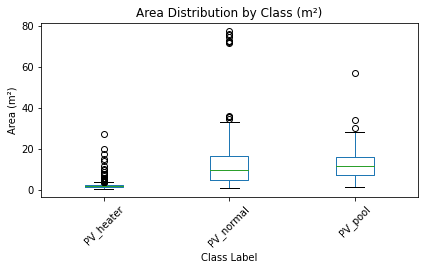

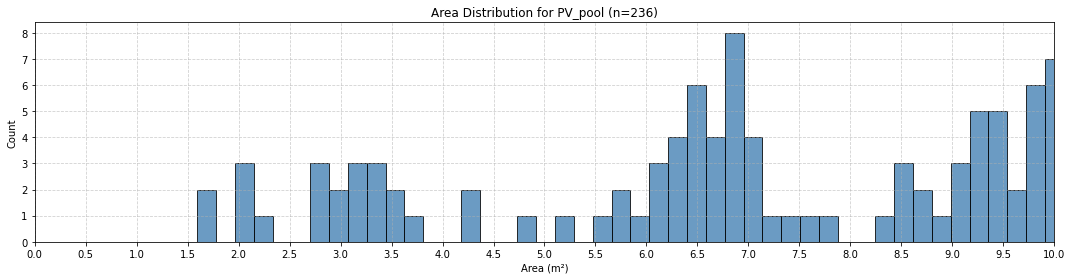

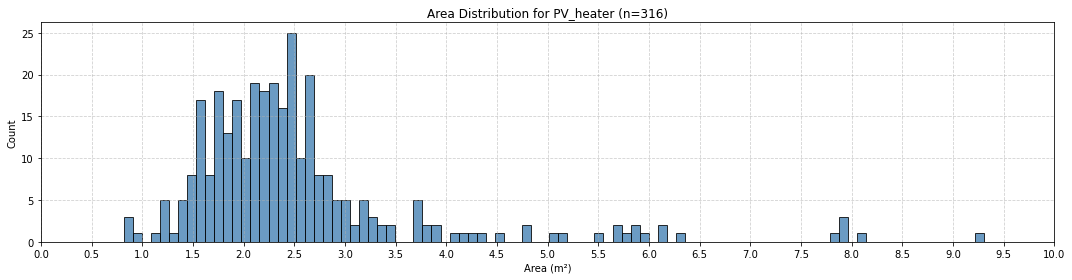

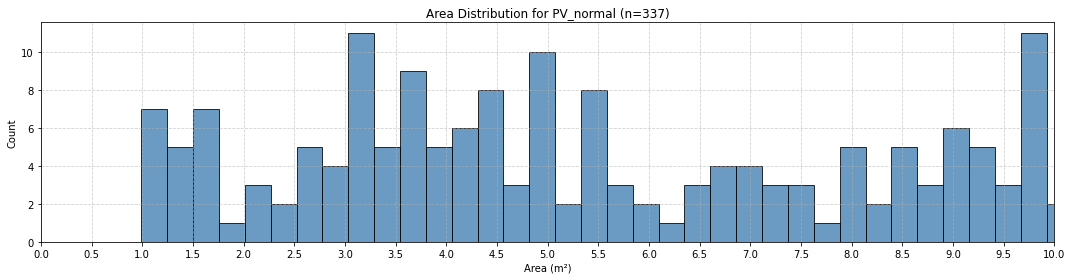

In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Compute polygon area (m²)
gt_long_proj = gt_long.copy()
gt_long_proj["area_m2"] = gt_long_proj.geometry.area

# Summary statistics per class
summary_stats = (
    gt_long_proj.groupby("label")["area_m2"]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .rename(columns={"25%": "Q1", "50%": "median", "75%": "Q3"})
)
print("=== Summary Statistics by Class (area_m2) ===")
display(summary_stats)

# Boxplot – Area distribution by class
plt.figure(figsize=(10, 6))
gt_long_proj.boxplot(column="area_m2", by="label", grid=False)
plt.title("Area Distribution by Class (m²)")
plt.suptitle("")
plt.xlabel("Class Label")
plt.ylabel("Area (m²)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histograms – One per class (fine-grained x-axis)
for lbl in gt_long_proj["label"].unique():
    subset = gt_long_proj.loc[gt_long_proj["label"] == lbl, "area_m2"]

    plt.figure(figsize=(15, 4))
    plt.hist(subset, bins=300, color="steelblue", edgecolor="black", alpha=0.8)
    plt.title(f"Area Distribution for {lbl} (n={len(subset)})")
    plt.xlabel("Area (m²)")
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.6)

    xmin, xmax = plt.xlim()
    tick_start = np.floor(xmin)
    tick_end = np.ceil(xmax)
    tick_interval = 0.5  # Set to 0.5 m² for finer granularity
    ticks = np.arange(tick_start, tick_end + tick_interval, tick_interval)
    plt.xticks(ticks)

    plt.xlim(0, min(xmax, 10))
    plt.tight_layout()
    plt.show()


**Filter prediction by area threshold**

*Note*<br>
=== Area-based Filtering Summary ===<br>
Total polygons before filtering : 1605<br>
Polygons < 1.7 m²     : 558<br>
Polygons ≥ 1.7 m²     : 1047<br>

In [21]:
# Threshold for small polygons
AREA_THRESHOLD = 1.7  # m²
# AREA_THRESHOLD = 0.816  # m² This returns 8% higher FN 

# Count polygons smaller than threshold
small_count = (merged_gdf_with_area["pred_area_m2"] < AREA_THRESHOLD).sum()

# Total before filtering
total_count = len(merged_gdf_with_area)

# Count polygons that remain
remaining_count = total_count - small_count

print("=== Area-based Filtering Summary ===")
print(f"Total polygons before filtering : {total_count}")
print(f"Polygons < {AREA_THRESHOLD} m²     : {small_count}")
print(f"Polygons ≥ {AREA_THRESHOLD} m²     : {remaining_count}")

# Optionally, show polygons that remain (>= threshold)
remained_polygons = merged_gdf_with_area[merged_gdf_with_area["pred_area_m2"] >= AREA_THRESHOLD]
display(remained_polygons.head(10))


=== Area-based Filtering Summary ===
Total polygons before filtering : 1011
Polygons < 1.7 m²     : 164
Polygons ≥ 1.7 m²     : 847


,gt_idx,gt_label,pred_label,pred_ids,match_type,clean_union_geom,merged_from,pred_area_m2
0,11.0,PV_pool,PV_pool,"[i_2023_RGB_8cm_W57B_8_pred_d9b17f98, i_2023_R...",same_class,"POLYGON ((-52367.16 -3771082.76, -52367.08 -37...","[11, 12]",28.8096
1,18.0,PV_normal,PV_normal,"[i_2023_RGB_8cm_W57B_8_pred_47a47090, i_2023_R...",same_class,"POLYGON ((-52326.04 -3771021.56, -52325.96 -37...","[19, 20]",19.0464
2,40.0,PV_normal,PV_normal,"[i_2023_RGB_8cm_W57B_8_pred_f4af2b36, i_2023_R...",same_class,"MULTIPOLYGON (((-52016.44 -3771017, -52016.36 ...","[41, 42, 43]",23.2000
3,47.0,PV_normal,PV_pool,"[i_2023_RGB_8cm_W57B_8_pred_ff4cef4d, i_2023_R...",diff_class,"POLYGON ((-52005.88 -3771059.24, -52005.8 -377...","[49, 50]",9.9424
4,87.0,PV_normal,PV_normal,"[i_2023_RGB_8cm_W57B_8_pred_b8c94dc7, i_2023_R...",same_class,"POLYGON ((-52975.56 -3771291.96, -52975.48 -37...","[89, 90]",9.5904
5,97.0,PV_normal,PV_normal,"[i_2023_RGB_8cm_W57B_8_pred_2542710b, i_2023_R...",same_class,"MULTIPOLYGON (((-52970.28 -3771293.48, -52970....","[99, 92]",4.6944
6,139.0,PV_pool,PV_pool,"[i_2023_RGB_8cm_W57B_8_pred_1172f374, i_2023_R...",same_class,"POLYGON ((-52721.4 -3771417.48, -52721.32 -377...","[141, 142]",19.6544
7,169.0,PV_normal,PV_normal,"[i_2023_RGB_8cm_W57B_8_pred_4f305642, i_2023_R...",same_class,"POLYGON ((-52403.72 -3771784.44, -52403.64 -37...","[171, 172, 173]",77.7184
8,172.0,PV_normal,PV_normal,"[i_2023_RGB_8cm_W57B_8_pred_cdb320f8, i_2023_R...",same_class,"POLYGON ((-52434.04 -3771761.48, -52433.96 -37...","[174, 175]",24.1792
9,174.0,PV_normal,PV_normal,"[i_2023_RGB_8cm_W57B_8_pred_6acd8fb7, i_2023_R...",same_class,"POLYGON ((-52427.64 -3771763.16, -52427.56 -37...","[176, 177]",41.0688


#### **Evaluation**

**COCO-style Instance-level Evaluation for Polygon-based Predictions (IoU-based Matching)**

- This script implements a COCO-style evaluation protocol tailored for polygon-based instance predictions **without confidence scores**. Instead of confidence ranking, it performs a deterministic one-to-one matching between predictions and ground truth
polygons based purely on Intersection over Union (IoU).

--------------
- Key Features:
1. One-to-One Matching (COCO Rule, IoU-based):
   - Each ground truth (GT) polygon can be matched to at most one predicted polygon,
     and vice versa.
   - Matching is determined solely by the highest IoU above the threshold (default = 0.5).

2. Max-IoU Matching Strategy:
   - For each prediction, the GT with the highest IoU is selected.
   - If multiple predictions overlap the same GT, only the one with the highest IoU
     is counted as a True Positive (TP); all others are treated as False Positives (FP).

3. Outcome Definitions:
   - TP: IoU >= threshold and class labels match.
   - FP_mismatch: IoU >= threshold but class labels differ.
   - FP_pure: No GT matched (IoU below threshold or duplicate detection).
   - FN_missed: GT polygon not matched by any prediction.

4. Strict FP Handling (No Confidence-based Filtering):
   - All predictions are treated equally, since no confidence scores are available.
   - Duplicate detections, partial overlaps, and class mismatches are all counted as FP.
   - This makes the evaluation **precision-oriented**, consistent with COCO's 1:1 rule.

**Notes:**
- This evaluation protocol is ideal for post-processed segmentation results where
  polygons represent discrete detected objects.
- However, it may over-penalize models that produce fragmented masks
  (i.e., over-segmentation), since each small fragment beyond the best-IoU match
  will be treated as a False Positive.
- Under-Segemtation can occur, when one prediction spans multiple GT instances, the evaluation does not allow one prediction to match multiple GTs. Therefore FN increases and recall decreases. To prevent this, watershed technique can be considered. 
----

**1+2+3 Output**
| Class      | TP  | FP  | FN  | *Precision* | *Recall*  |
|------------|-----|-----|-----|-----------|---------|
| PV_normal  | 243 | 68 | 89  | 0.7813    | 0.7319  |
| PV_heater  | 220 | 62 | 83 | 0.7801    | 0.7260  |
| PV_pool    | 161 | 51 | 63  | 0.7594    | 0.7187  |

**1+2 Output** 

| Class      | TP  | FP  | FN  | *Precision* | *Recall*  |
|------------|-----|-----|-----|-----------|---------|
| PV_normal  | 243 | 86 | 89  | 0.7386    | 0.7319  |
| PV_heater  | 221 | 105 | 82 | 0.6779    | 0.7293  |
| PV_pool    | 161 | 87 | 63  | 0.6491    | 0.7187  |

*Precision = TP / (TP + FP), Recall = TP / (TP + FN)*<br>

**1 Output**

| Class      | TP  | FP  | FN  | *Precision* | *Recall*  |
|------------|-----|-----|-----|-----------|---------|
| PV_normal  | 245 | 443 | 91  | 0.3561    | 0.7291  |
| PV_heater  | 191 | 330 | 86 | 0.3666    | 0.6895  |
| PV_pool    | 163 | 188 | 61  | 0.4643    | 0.7276  |

*Precision = TP / (TP + FP), Recall = TP / (TP + FN)*<br>


**NOTE**: Pixel-level Evaluation<br>

- *1024 image size, epoch 34* (BEST)  

| Class      | IoU   | *Precision* | *Recall* |
|------------|-------|-----------|--------|
| PV_normal  | 0.7425 | 0.8220    | 0.8847 |
| PV_heater  | 0.5610 | 0.7251    | 0.7125 |
| PV_pool    | 0.6803 | 0.7680    | 0.8563 |


*Remark1. In pixel-level evaluation, even small objects can improve the score as long as some pixels overlap with the GT. However, in instance-level evaluation, if the predicted object does not reach the IoU threshold with the GT, it is counted as a complete miss. Therefore, many partial detections below the IoU threshold is expected to be observed at the instance level*

*Remark2. The current evaluation pipeline first identifies ground-truth (GT) polygons and, for each GT, merges all fragmented predictions of the same class into a single polygon. Matching is then performed based on the GT’s class; only predictions with the same label are considered for IoU matching, while predictions of other classes are treated as false positives. However, this merging behavior is only possible because GT is known—such GT-guided merging cannot be applied in real inference scenarios where ground truth is unavailable.*

In [17]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

def compute_iou(poly1, poly2):
    """
    Compute IoU (Intersection over Union) between two polygons.
    Returns 0 if polygons are None or non-overlapping.
    """
    if poly1 is None or poly2 is None:
        return 0.0
    inter = poly1.intersection(poly2)
    if inter.is_empty:
        return 0.0
    return inter.area / (poly1.union(poly2).area)


def evaluate_predictions(gt_gdf, pred_gdf, iou_thr=0.5):
    """
    Evaluate instance-level predictions against ground truth polygons (true COCO-style).

    Implements one-to-one matching between GT and Predictions:
      - Each prediction can match at most one GT (and vice versa).
      - Matching is based on highest IoU above threshold.

    Outcome types:
      TP: IoU >= thr and class matches
      FP_mismatch: IoU >= thr but wrong class
      FP_pure: prediction with no matched GT
      FN: GT with no matched prediction
    """

    # --- Compute IoU matrix ---
    iou_matrix = np.zeros((len(gt_gdf), len(pred_gdf)))

    for i, (_, gt_row) in enumerate(gt_gdf.iterrows()):
        for j, (_, pred_row) in enumerate(pred_gdf.iterrows()):
            iou_matrix[i, j] = compute_iou(
                gt_row.geometry,
                pred_row.clean_union_geom
            )

    matched_gt = set()
    matched_pred = set()
    records = []

    # --- Match each prediction to best GT (IoU max) ---
    for j, (_, pred_row) in enumerate(pred_gdf.iterrows()):
        best_iou = 0.0
        best_gt_idx = None
        for i, (_, gt_row) in enumerate(gt_gdf.iterrows()):
            if i in matched_gt:
                continue  # COCO one-to-one rule
            iou = iou_matrix[i, j]
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i

        pred_label = pred_row.pred_label
        if best_gt_idx is not None and best_iou >= iou_thr:
            gt_label = gt_gdf.loc[best_gt_idx, "label"]

            if gt_label == pred_label:
                records.append((best_gt_idx, gt_label, pred_label, best_iou, "TP", None))
            else:
                records.append((best_gt_idx, gt_label, pred_label, best_iou, "FP", "FP_mismatch"))
            matched_gt.add(best_gt_idx)
            matched_pred.add(j)
        else:
            # No valid match → pure FP
            records.append((None, None, pred_label, None, "FP", "FP_pure"))

    # --- Remaining unmatched GTs → FN ---
    for i, (_, gt_row) in enumerate(gt_gdf.iterrows()):
        if i not in matched_gt:
            records.append((i, gt_row.label, None, None, "FN", "FN_missed"))

    # --- Build eval dataframe ---
    eval_df = pd.DataFrame(records, columns=["gt_idx", "gt_label", "pred_label", "IoU", "outcome", "subtype"])

    # -----------------------------------
    # 2. Per-class COCO-style metrics
    # -----------------------------------
    metrics = []
    classes = sorted(set(gt_gdf["label"].dropna()) | set(pred_gdf["pred_label"].dropna()))

    for c in classes:
        tp = ((eval_df["gt_label"] == c) & (eval_df["outcome"] == "TP")).sum()
        fp = (((eval_df["pred_label"] == c) & (eval_df["outcome"] == "FP")).sum())
        fn = ((eval_df["gt_label"] == c) & (eval_df["outcome"] == "FN")).sum()

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        metrics.append((c, tp, fp, fn, prec, rec))

    metrics_df = pd.DataFrame(metrics, columns=["class", "TP", "FP", "FN", "Precision", "Recall"])

    desired_order = ["PV_normal", "PV_heater", "PV_pool"]
    metrics_df = (
        metrics_df.set_index("class")
        .reindex(desired_order)
        .reset_index()
    )

    # -----------------------------------
    # 3. Misclassification (FP_mismatch)
    # -----------------------------------
    misclassified = eval_df[
        (eval_df["subtype"] == "FP_mismatch") &
        (eval_df["gt_label"].notna()) &
        (eval_df["pred_label"].notna())
    ]

    misclass_df = (
        misclassified.groupby(["gt_label", "pred_label"])
        .size()
        .reset_index(name="count")
    )

    gt_counts = eval_df["gt_label"].value_counts()
    misclass_df["gt_total"] = misclass_df["gt_label"].map(gt_counts)
    misclass_df["percentage_of_class"] = (misclass_df["count"] / misclass_df["gt_total"]) * 100

    misclass_matrix = (
        misclass_df.pivot(index="gt_label", columns="pred_label", values="count")
        .fillna(0)
        .astype(int)
    )

    # -----------------------------------
    # 4. Overall metrics
    # -----------------------------------
    tp_total = metrics_df["TP"].sum()
    fp_total = metrics_df["FP"].sum()
    fn_total = metrics_df["FN"].sum()

    overall = {
        "Precision": tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0.0,
        "Recall": tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0.0,
        "TP": tp_total,
        "FP": fp_total,
        "FN": fn_total
    }

    return eval_df, metrics_df, misclass_df, misclass_matrix, overall


# -----------------------------
# Usage Example
# -----------------------------
eval_df, metrics_df, misclass_df, misclass_matrix, overall = evaluate_predictions(
    gt_long, remained_polygons, iou_thr=IOU_THRESHOLD
)

print("=== Evaluation Records (sample) ===")
display(eval_df.sample(10))

print("=== Per-class Metrics (COCO-style) ===")
display(metrics_df)

print("=== Misclassification Details ===")
display(misclass_df)

print("=== Confusion Matrix (GT vs Pred) ===")
display(misclass_matrix)

print("=== Overall Metrics (COCO-style) ===")
print(overall)

=== Evaluation Records (sample) ===


,gt_idx,gt_label,pred_label,IoU,outcome,subtype
443,540.0,PV_heater,PV_heater,0.649768,TP,None
735,NaN,None,PV_heater,NaN,FP,FP_pure
639,800.0,PV_heater,PV_heater,0.554114,TP,None
545,687.0,PV_heater,PV_heater,0.843776,TP,None
620,779.0,PV_heater,PV_heater,0.851720,TP,None
425,512.0,PV_pool,PV_pool,0.883690,TP,None
925,458.0,PV_pool,None,NaN,FN,FN_missed
524,649.0,PV_normal,PV_normal,0.926708,TP,None
368,436.0,PV_heater,PV_heater,0.695390,TP,None
27,350.0,PV_pool,PV_pool,0.802785,TP,None


=== Per-class Metrics (COCO-style) ===


,class,TP,FP,FN,Precision,Recall
0,PV_normal,243,68,89,0.781350,0.731928
1,PV_heater,220,62,83,0.780142,0.726073
2,PV_pool,161,51,63,0.759434,0.718750


=== Misclassification Details ===


,gt_label,pred_label,count,gt_total,percentage_of_class
0,PV_heater,PV_normal,9,316,2.848101
1,PV_heater,PV_pool,4,316,1.265823
2,PV_normal,PV_heater,1,337,0.296736
3,PV_normal,PV_pool,4,337,1.186944
4,PV_pool,PV_heater,4,236,1.694915
5,PV_pool,PV_normal,8,236,3.389831


=== Confusion Matrix (GT vs Pred) ===


pred_label,PV_heater,PV_normal,PV_pool
gt_label,,,
PV_heater,0,9,4
PV_normal,1,0,4
PV_pool,4,8,0


=== Overall Metrics (COCO-style) ===
{'Precision': 0.7751552795031056, 'Recall': 0.7264260768335273, 'TP': 624, 'FP': 181, 'FN': 235}


**GPKG for Visualization**

- TP (True Positive)
    - GT exists, model predicts the correct class, and IoU ≥ threshold (0.5 here)
    - Correct detection

- FP_pure (False Positive – pure)
    - No GT exists, but the model predicts a positive.Completely
    - Wrong detection

- FP_mismatch (False Positive – mismatch)
    - GT exists, but wrong detection despite GT presence.
        - (1) The model predicts the wrong class, or
        - (2) IoU < threshold, so overlap is insufficient.

- FN_missed (False Negative – missed)
    - GT exists, but the model does not detect anything (no overlap at all).
    - Completely missed detection.

- FN_overlap (False Negative – overlap)
    - GT exists, model partially detects it, but IoU is below threshold.
    - Partially captured but insufficient to be considered TP. 
        - main cause of poor instance-level evaluation due to partial detection

**Export GPKG file for visualizaion**

In [ ]:
# -------------------------------------------------------------------
# 1. Build Evaluation Table (with metadata)
# -------------------------------------------------------------------
output_gpkg = '/shared/data/climateplus2025/Post_Processing_with_Evaluation_1024_Nov20/1+2+3.Drop_small_polygons/eval_results_clean_v0_1.gpkg'

records = []

cleaned_union_df = cleaned_union_df.drop_duplicates(subset=["gt_idx"], keep="first")

for _, row in union_df.iterrows():
    gt_idx = row["gt_idx"]
    gt_label = row["gt_label"]
    pred_label = row["pred_label"]
    pred_geom = row["union_pred_geom"]

    # --- safely extract metadata ---
    meta = row.get("metadata", {})
    if not isinstance(meta, dict):
        meta = {}

    # ---- Prediction IDs ----
    pred_id_list = row.get("pred_ids", [])
    pred_id_str = ", ".join(map(str, pred_id_list)) if pred_id_list else None

    # ---- Case 1: FP (no GT matched) ----
    if pd.isna(gt_idx):
        records.append({
            "gt_idx": None,
            "gt_id": None,
            "gt_label": None,
            "pred_label": pred_label,
            "prediction_ids": pred_id_str,
            "image_name": meta.get("image_name"),
            "area_m2_list": meta.get("area_m2_list"),
            "centroid_pixel": meta.get("centroid_pixel"),
            "centroid_gps": meta.get("centroid_gps"),
            "IoU": None,
            "outcome": "FP",
            "subtype": "FP_pure",
            "geometry": pred_geom
        })
        continue


    # ---- Case 2: GT exists ----
    gt_geom = gt_long.loc[gt_idx, "geometry"]
    gt_id = gt_long.loc[gt_idx, "id"] if "id" in gt_long.columns else gt_idx
    iou = compute_iou(gt_geom, pred_geom)
    iou = round(iou, 3) if iou else 0.0

    # ---- Determine outcome/subtype ----
    if pred_geom is None or pred_label is None:
        outcome, subtype, chosen_geom = "FN", "FN_missed", gt_geom
    elif iou >= IOU_THRESHOLD and pred_label == gt_label:
        outcome, subtype, chosen_geom = "TP", None, pred_geom
    elif iou >= IOU_THRESHOLD and pred_label != gt_label:
        outcome, subtype, chosen_geom = "FP", "FP_mismatch", pred_geom
    elif 0 < iou < IOU_THRESHOLD:
        outcome, subtype, chosen_geom = "FN", "FN_overlap", pred_geom
    else:
        outcome, subtype, chosen_geom = "FN", "FN_missed", gt_geom

    # ---- Append record ----
    records.append({
        "gt_idx": gt_idx,
        "gt_id": gt_id,
        "gt_label": gt_label,
        "pred_label": pred_label,
        "prediction_ids": pred_id_str,
        "image_name": meta.get("image_name"),
        "area_m2_list": meta.get("area_m2_list"),
        "centroid_pixel": meta.get("centroid_pixel"),
        "centroid_gps": meta.get("centroid_gps"),
        "IoU": iou,
        "outcome": outcome,
        "subtype": subtype,
        "geometry": chosen_geom
    })

# -------------------------------------------------------------------
# 2. Add Missing GTs (FN_missed)
# -------------------------------------------------------------------
all_gt_idx = set(gt_long.index)
covered_gt_idx = set(union_df["gt_idx"].dropna())
missed_gt_idx = all_gt_idx - covered_gt_idx

for idx in missed_gt_idx:
    gt_geom = gt_long.loc[idx, "geometry"]
    gt_label = gt_long.loc[idx, "label"]
    gt_id = gt_long.loc[idx, "id"] if "id" in gt_long.columns else idx

    records.append({
        "gt_idx": idx,
        "gt_id": gt_id,
        "gt_label": gt_label,
        "pred_label": None,
        "prediction_ids": None,
        "image_name": None,
        "area_m2_list": None,
        "centroid_pixel": None,
        "centroid_gps": None,
        "IoU": 0.0,
        "outcome": "FN",
        "subtype": "FN_missed",
        "geometry": gt_geom
    })

# -------------------------------------------------------------------
# 3. Build Final GeoDataFrame
# -------------------------------------------------------------------
eval_pred_final = gpd.GeoDataFrame(records, geometry="geometry", crs=gt_long.crs)

print("Evaluation_Pred_cleaned_final shape:", eval_pred_final.shape)
display(eval_pred_final.head(10))

# -------------------------------------------------------------------
# Geometry & Area normalization
# -------------------------------------------------------------------
from shapely.geometry import MultiPolygon

def safe_to_multipolygon(g):
    if g is None or g.is_empty:
        return g
    if g.geom_type == "Polygon":
        return MultiPolygon([g])
    elif g.geom_type == "MultiPolygon":
        return g
    else:
        return None

eval_pred_final["geometry"] = eval_pred_final["geometry"].apply(safe_to_multipolygon)

if eval_pred_final.crs != gt_long.crs:
    eval_pred_final = eval_pred_final.to_crs(gt_long.crs)

eval_pred_final["area_m2"] = eval_pred_final.geometry.area

print("Geometry normalized & area recalculated before GPKG save.")
print(eval_pred_final.geometry.geom_type.value_counts(dropna=False))

# -------------------------------------------------------------------
# 4. Save to GPKG
# -------------------------------------------------------------------
gt_long.to_file(output_gpkg, layer="GT", driver="GPKG", mode="w")
eval_pred_final.to_file(output_gpkg, layer="Evaluation_Pred_cleaned_final_FP_included", driver="GPKG", mode="a")

print(f"Final GPKG saved → {output_gpkg}")
print("Layers: [GT] + [Evaluation_Pred_cleaned_final]")

Evaluation_Pred_cleaned_final shape: (1087, 13)


,gt_idx,gt_id,gt_label,pred_label,prediction_ids,image_name,area_m2_list,centroid_pixel,centroid_gps,IoU,outcome,subtype,geometry
0,0.0,4208.0,PV_pool,None,None,None,None,None,None,0.000,FN,FN_missed,"POLYGON ((-52883.171 -3771011.424, -52882.308 ..."
1,1.0,4209.0,PV_pool,None,None,None,None,None,None,0.000,FN,FN_missed,"POLYGON ((-52887.001 -3771000.514, -52885.919 ..."
2,2.0,4210.0,PV_pool,None,None,None,None,None,None,0.000,FN,FN_missed,"POLYGON ((-52866.993 -3771092.457, -52863.88 -..."
3,3.0,4211.0,PV_heater,PV_heater,i_2023_RGB_8cm_W57B_8_pred_45edc9d4,None,1.7504,None,None,0.872,TP,None,"POLYGON ((-52853.96 -3771035.96, -52854.04 -37..."
4,4.0,4212.0,PV_heater,PV_heater,i_2023_RGB_8cm_W57B_8_pred_55e89525,None,1.5872,None,None,0.812,TP,None,"POLYGON ((-52731.48 -3771083, -52731.56 -37710..."
5,5.0,4213.0,PV_heater,None,None,None,None,None,None,0.000,FN,FN_missed,"POLYGON ((-52751.743 -3771044.253, -52750.068 ..."
6,6.0,4214.0,PV_heater,PV_heater,i_2023_RGB_8cm_W57B_8_pred_3465f6c5,None,2.3104,None,None,0.905,TP,None,"POLYGON ((-52762.84 -3771001.48, -52762.92 -37..."
7,7.0,4215.0,PV_pool,PV_pool,i_2023_RGB_8cm_W57B_8_pred_6592a29a,None,22.2688,None,None,0.934,TP,None,"POLYGON ((-52596.28 -3771059.8, -52596.28 -377..."
8,8.0,4216.0,PV_pool,PV_pool,i_2023_RGB_8cm_W57B_8_pred_30878ed3,None,16.544,None,None,0.904,TP,None,"POLYGON ((-52605 -3771032.52, -52605 -3771032...."
9,9.0,4217.0,PV_pool,None,None,None,None,None,None,0.000,FN,FN_missed,"POLYGON ((-52594.928 -3771005.783, -52588.907 ..."


Geometry normalized & area recalculated before GPKG save.
MultiPolygon    1087
Name: count, dtype: int64
Final GPKG saved → /shared/data/climateplus2025/Post_Processing_with_Evaluation_1024_Nov20/1+2.Group_neighboring_polygons/eval_results_clean_v0_1.gpkg
Layers: [GT] + [Evaluation_Pred_cleaned_final]


**Export CSV format for installation year detection**

In [ ]:
#Save as CSV

output_csv_dir = "/shared/data/climateplus2025/Post_Processing_with_Evaluation_1024_Nov20/1+2+3.Drop_small_polygons/Output_CSV_FP_included"
os.makedirs(output_csv_dir, exist_ok=True)

# Save GT as CSV
gt_csv_path = os.path.join(output_csv_dir, "GT.csv")
gt_long.to_csv(gt_csv_path, index=False)
print(f"GT layer also saved as CSV → {gt_csv_path}")

# Save Evaluation results as CSV (convert geometry to WKT)
eval_pred_csv_path = os.path.join(output_csv_dir, "Evaluation_Pred_cleaned_final.csv")
eval_pred_final_copy = eval_pred_final.copy()
eval_pred_final_copy["geometry"] = eval_pred_final_copy["geometry"].apply(lambda g: g.wkt if g is not None else None)
eval_pred_final_copy.to_csv(eval_pred_csv_path, index=False)
print(f"Evaluation_Pred_cleaned_final layer also saved as CSV → {eval_pred_csv_path}")

GT layer also saved as CSV → /shared/data/climateplus2025/Post_Processing_with_Evaluation_1024_Nov20/1.Connect_adjacent_pixels/Output_CSV_FP_included/GT.csv
Evaluation_Pred_cleaned_final layer also saved as CSV → /shared/data/climateplus2025/Post_Processing_with_Evaluation_1024_Nov20/1.Connect_adjacent_pixels/Output_CSV_FP_included/Evaluation_Pred_cleaned_final.csv


/tmp/ipykernel_713896/854563109.py:14: UserWarning: Geometry column does not contain geometry.
  eval_pred_final_copy["geometry"] = eval_pred_final_copy["geometry"].apply(lambda g: g.wkt if g is not None else None)
